<div align="center"><FONT FACE="times new roman" SIZE=5>
<img src="https://raw.githubusercontent.com/CamiloHedzz/ProcesamientoImagenes/main/LogoUSA.png" ></img>
<div align="center"><FONT FACE="times new roman" SIZE=5>
    <i><b>Docente:</b></i> Darwin Martínez<br>
    <i><b>Asignatura:</b></i> Introduccion a Sistemas Inteligentes<br>
    <i><b>Tema:</b></i> Cadena de distribución de drones - Algoritmo bio-inspirado AVES (PSO)<br>
    <i><b>Estudiantes: </b></i>Camilo Hernández, Juan Arias, Christian Jiménez<br>
</div>

In [9]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from matplotlib.animation import FuncAnimation
from tabulate import tabulate


# **Introduccion**


**Algoritmo de aves bioinspirado**


 Es un método computacional que optimiza un problema intentando mejorar de forma iterativa una solución candidata con respecto a una determinada medida de calidad. Resuelve un problema disponiendo de una población de soluciones candidatas, denominadas partículas, y moviéndolas en el espacio de búsqueda de acuerdo con fórmulas matemáticas sencillas sobre la posición y la velocidad de la partícula. El movimiento de cada partícula está influido por su mejor posición local conocida, pero también está guiado hacia las mejores posiciones conocidas en el espacio de búsqueda, que se actualizan a medida que otras partículas encuentran mejores posiciones. De este modo, se espera que el enjambre se dirija hacia las mejores soluciones.



 <img src='https://upload.wikimedia.org/wikipedia/commons/e/ec/ParticleSwarmArrowsAnimation.gif'></img>



**Caracteristicas principales**

- Comportamiento social: En una bandada de aves, cada individuo sigue reglas simples,
como la alineación con sus vecinos, la atracción hacia la mejor fuente de alimento y
el evitar colisiones.
- Enjambre de partículas: En el algoritmo, las aves se modelan como "partículas" que
se mueven en un espacio de soluciones. Cada partícula representa una posible
solución a un problema de optimización.
- Velocidad y posición: Cada partícula tiene una posición y una velocidad, que se
actualizan en cada iteración. La actualización de la velocidad está influenciada por
dos factores:
● La mejor posición encontrada por la propia partícula.
● La mejor posición global encontrada por el enjambre.


# **1. Cargar Datos**

## **Descripción:**
Este módulo se encarga de cargar los datos del archivo CSV que contiene las coordenadas, demandas y otros detalles de los centros comerciales. También visualiza el contenido del CSV para verificar su estructura y contenido.

## **Funcionalidades:**
- Importa los datos desde un archivo CSV a un DataFrame utilizando `pandas`.
- Muestra todo el contenido del archivo CSV en formato tabular para facilitar la revisión de los datos.


In [10]:
# Cargar datos del archivo CSV
ruta_csv = 'https://raw.githubusercontent.com/Juanariasp/Algoritmo-Bio-Inspirado/refs/heads/main/Codigo/Centros_Comerciales_Bogota_Normalized.csv'
data = pd.read_csv(ruta_csv, delimiter=",")

# Mostrar el contenido del CSV en formato tabular
print("Datos del CSV:")
print(tabulate(data, headers='keys', tablefmt='grid'))

# Extraer coordenadas y demandas
coordenadas = data[['Latitud', 'Longitud']].apply(tuple, axis=1).tolist()
demandas = data['Demanda'].tolist()
centro_distribucion = (4.641365, -74.105120)  # Centro de distribución


Datos del CSV:
+----+------+---------------------------+---------------------------------------------+-----------+------------+-----------+
|    |   ID | Nombre                    | Direccion                                   |   Latitud |   Longitud |   Demanda |
+====+======+===========================+=============================================+===========+============+===========+
|  0 |    1 | Iserra 100                | Transversal 55 No. 98 A 66                  |    4.6835 |   -74.0647 |        10 |
+----+------+---------------------------+---------------------------------------------+-----------+------------+-----------+
|  1 |    2 | Santafe                   | Calle 185 No. 45 – 03                       |    4.7639 |   -74.0395 |        20 |
+----+------+---------------------------+---------------------------------------------+-----------+------------+-----------+
|  2 |    3 | Centro Mayor              | AV. NQS con 38 A Sur                        |    4.5895 |   -74.127 

# **2. Configuración de Parámetros**

## **Descripción:**
Este módulo define una clase para gestionar los parámetros del algoritmo PSO, permitiendo configurar valores iniciales como el número de partículas, iteraciones, capacidad máxima de los vehículos, entre otros.

## **Funcionalidades:**
- Centraliza todos los parámetros del algoritmo PSO en una única clase.
- Permite modificar dinámicamente los valores de los parámetros a través de un método específico.


In [11]:
class ConfiguracionPSO:
    """
    Clase para configurar y gestionar los parámetros del algoritmo PSO.
    """
    def __init__(self):
        # Parámetros de PSO
        self.num_particulas = 10            # Número de partículas
        self.max_iteraciones = 50          # Número máximo de iteraciones
        self.factor_inercia = 0.5          # Factor de inercia (w)
        self.coeficiente_cognitivo = 1.5   # Coeficiente cognitivo (c1)
        self.coeficiente_social = 1.5      # Coeficiente social (c2)

        # Parámetros del problema de vehículos
        self.num_vehiculos = 5             # Número de vehículos
        self.capacidad_vehiculo = 50       # Capacidad máxima de los vehículos

    def modificar_parametros(self, **kwargs):
        """
        Modifica los parámetros de configuración.
        :param kwargs: Diccionario con los nombres y valores de los parámetros a modificar.
        """
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                print(f"Parámetro '{key}' no encontrado en la configuración.")


# **3. Funciones Utilitarias**

## **Descripción:**
Este módulo contiene funciones auxiliares necesarias para la implementación del PSO, como el cálculo de distancias y la división de rutas en subrutas basadas en la capacidad de los vehículos.

## **Funcionalidades:**
- Calcula la distancia total de una ruta considerando el centro de distribución y las ubicaciones de los clientes.
- Divide una ruta en subrutas respetando la capacidad máxima de los vehículos.


In [12]:
def calcular_distancia_total(ruta, centro, ubicaciones):
    """
    Calcula la distancia total para una ruta que comienza y termina en el centro de distribución.
    """
    distancia_total = 0.0
    ubicacion_actual = centro
    for indice in ruta:
        siguiente_ubicacion = ubicaciones[indice]
        distancia_total += geodesic(ubicacion_actual, siguiente_ubicacion).kilometers
        ubicacion_actual = siguiente_ubicacion
    distancia_total += geodesic(ubicacion_actual, centro).kilometers
    return distancia_total

def dividir_ruta_por_capacidad(ruta, demandas, capacidad_maxima):
    """
    Divide una ruta en subrutas basadas en la capacidad del vehículo.
    """
    subrutas = []
    capacidad_actual = capacidad_maxima
    subruta = []
    for cliente in ruta:
        if demandas[cliente] <= capacidad_actual:
            subruta.append(cliente)
            capacidad_actual -= demandas[cliente]
        else:
            subrutas.append(subruta)
            subruta = [cliente]
            capacidad_actual = capacidad_maxima - demandas[cliente]
    if subruta:
        subrutas.append(subruta)
    return subrutas


# **4. Implementación del Algoritmo PSO**

## **Descripción:**
Este módulo implementa el algoritmo de Optimización por Enjambre de Partículas (PSO), permitiendo encontrar las rutas óptimas para satisfacer las demandas de los clientes.

## **Funcionalidades:**
- Define partículas que representan posibles soluciones al problema de ruteo.
- Optimiza las rutas utilizando principios de inercia, componentes cognitivas y sociales.
- Almacena el progreso de las iteraciones y las mejores soluciones encontradas.


In [13]:
class Particula:
    """
    Representa una partícula en el algoritmo PSO.
    """
    def __init__(self, num_clientes):
        self.ruta = np.random.permutation(num_clientes)  # Ruta inicial aleatoria
        self.velocidad = np.zeros(num_clientes)         # Velocidad no usada directamente
        self.mejor_ruta = self.ruta.copy()
        self.mejor_aptitud = float('inf')

    def evaluar_aptitud(self, centro, ubicaciones, demandas, capacidad_maxima):
        """
        Evalúa la aptitud de la partícula considerando distancias y capacidad.
        """
        subrutas = dividir_ruta_por_capacidad(self.ruta, demandas, capacidad_maxima)
        distancia_total = sum(calcular_distancia_total(subruta, centro, ubicaciones) for subruta in subrutas)
        if distancia_total < self.mejor_aptitud:
            self.mejor_aptitud = distancia_total
            self.mejor_ruta = self.ruta.copy()
        return distancia_total

class PSO:
    """
    Implementación del algoritmo de Optimización por Enjambre de Partículas (PSO).
    """
    def __init__(self, config, num_clientes, centro, ubicaciones, demandas):
        self.particulas = [Particula(num_clientes) for _ in range(config.num_particulas)]
        self.mejor_ruta_global = None
        self.mejor_aptitud_global = float('inf')
        self.centro = centro
        self.ubicaciones = ubicaciones
        self.demandas = demandas
        self.capacidad_maxima = config.capacidad_vehiculo
        self.iteraciones = config.max_iteraciones
        self.historial_aptitud = []

    def optimizar(self):
        """
        Ejecuta el algoritmo de optimización PSO.
        """
        for iteracion in range(self.iteraciones):
            for particula in self.particulas:
                aptitud = particula.evaluar_aptitud(self.centro, self.ubicaciones, self.demandas, self.capacidad_maxima)
                if aptitud < self.mejor_aptitud_global:
                    self.mejor_aptitud_global = aptitud
                    self.mejor_ruta_global = particula.mejor_ruta.copy()
            self.historial_aptitud.append(self.mejor_aptitud_global)
            self.actualizar_particulas()
            print(f"Iteración {iteracion + 1}/{self.iteraciones}, Mejor Aptitud Global: {self.mejor_aptitud_global:.2f} km")

    def actualizar_particulas(self):
        """
        Actualiza las partículas basándose en inercia, componente cognitiva y social.
        """
        for particula in self.particulas:
            nueva_ruta = np.random.permutation(len(self.ubicaciones))
            particula.ruta = nueva_ruta


# **5. Visualización de Resultados**

## **Descripción:**
Este módulo se encarga de visualizar las rutas optimizadas en un plano cartesiano. Muestra solo las iteraciones donde el valor del fitness cambia y etiqueta los puntos con los IDs de los centros comerciales.

## **Funcionalidades:**
- Genera gráficos de las rutas optimizadas en un plano cartesiano.
- Filtra las iteraciones para mostrar solo aquellas donde hay mejoras en el fitness.
- Etiqueta los puntos de las rutas con los IDs de los centros comerciales correspondientes.


In [14]:
import matplotlib.pyplot as plt

def visualizar_rutas_cambio_fitness(centro, coordenadas, pso, ids):
    """
    Muestra las rutas optimizadas en un plano cartesiano solo cuando hay un cambio en el valor de fitness.

    :param centro: Coordenadas del centro de distribución (latitud, longitud).
    :param coordenadas: Lista de coordenadas de los clientes (latitud, longitud).
    :param pso: Objeto del algoritmo PSO con historial de rutas por iteración.
    :param ids: Lista de IDs de los centros comerciales.
    """
    colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    fitness_previo = None  # Almacena el fitness de la iteración previa para comparación

    for iteracion, mejor_fitness in enumerate(pso.historial_aptitud):
        # Mostrar solo si el fitness cambia
        if mejor_fitness != fitness_previo:
            fitness_previo = mejor_fitness

            # Crear un nuevo gráfico
            plt.figure(figsize=(10, 8))
            plt.title(f"Iteración {iteracion + 1}/{pso.iteraciones}, Mejor Distancia: {mejor_fitness:.2f} km")
            plt.xlabel("Longitud")
            plt.ylabel("Latitud")
            plt.grid()

            # Dibujar la mejor ruta global y dividir en subrutas
            ruta = pso.mejor_ruta_global
            subrutas = dividir_ruta_por_capacidad(ruta, pso.demandas, pso.capacidad_maxima)

            for i, subruta in enumerate(subrutas):
                ruta_completa = [centro] + [coordenadas[idx] for idx in subruta] + [centro]
                latitudes, longitudes = zip(*ruta_completa)
                plt.plot(longitudes, latitudes, '-o', label=f"Subruta {i + 1}", color=colores[i % len(colores)])

                # Etiquetar los puntos con los IDs de los centros comerciales
                for idx, (lat, lon) in enumerate(zip(latitudes[1:-1], longitudes[1:-1])):
                    plt.text(lon, lat, f"{ids[subruta[idx]]}", fontsize=9, color='black', ha='center')

            # Dibujar el centro de distribución
            plt.scatter(centro[1], centro[0], color='black', label="Centro de Distribución", zorder=5)
            plt.legend(loc="upper right")

            # Ajustar los márgenes del gráfico
            plt.tight_layout()

            # Mostrar la gráfica
            plt.show()





In [17]:
# Crear una configuración para el PSO
config = ConfiguracionPSO()

# Modificar parámetros si es necesario
config.modificar_parametros(
    num_particulas=20,
    max_iteraciones=50,
    num_vehiculos=5,
    capacidad_vehiculo=50
)

# Ejecutar PSO
pso = PSO(config, len(coordenadas), centro_distribucion, coordenadas, demandas)
pso.optimizar()

# Obtener los IDs de los centros comerciales desde el CSV
ids_centros_comerciales = data['ID'].tolist()

Iteración 1/50, Mejor Aptitud Global: 386.25 km
Iteración 2/50, Mejor Aptitud Global: 366.24 km
Iteración 3/50, Mejor Aptitud Global: 366.24 km
Iteración 4/50, Mejor Aptitud Global: 366.24 km
Iteración 5/50, Mejor Aptitud Global: 366.24 km
Iteración 6/50, Mejor Aptitud Global: 366.24 km
Iteración 7/50, Mejor Aptitud Global: 366.24 km
Iteración 8/50, Mejor Aptitud Global: 366.24 km
Iteración 9/50, Mejor Aptitud Global: 366.24 km
Iteración 10/50, Mejor Aptitud Global: 361.94 km
Iteración 11/50, Mejor Aptitud Global: 361.94 km
Iteración 12/50, Mejor Aptitud Global: 361.94 km
Iteración 13/50, Mejor Aptitud Global: 361.94 km
Iteración 14/50, Mejor Aptitud Global: 361.94 km
Iteración 15/50, Mejor Aptitud Global: 361.94 km
Iteración 16/50, Mejor Aptitud Global: 361.94 km
Iteración 17/50, Mejor Aptitud Global: 361.94 km
Iteración 18/50, Mejor Aptitud Global: 361.94 km
Iteración 19/50, Mejor Aptitud Global: 361.94 km
Iteración 20/50, Mejor Aptitud Global: 361.94 km
Iteración 21/50, Mejor Aptitu

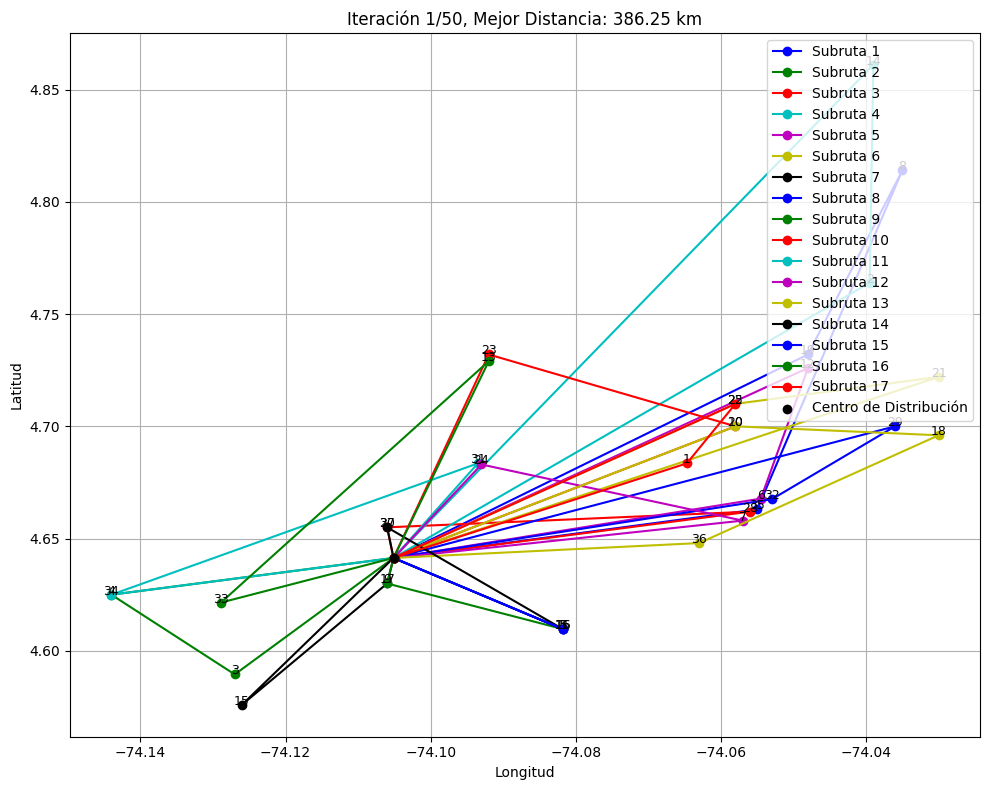

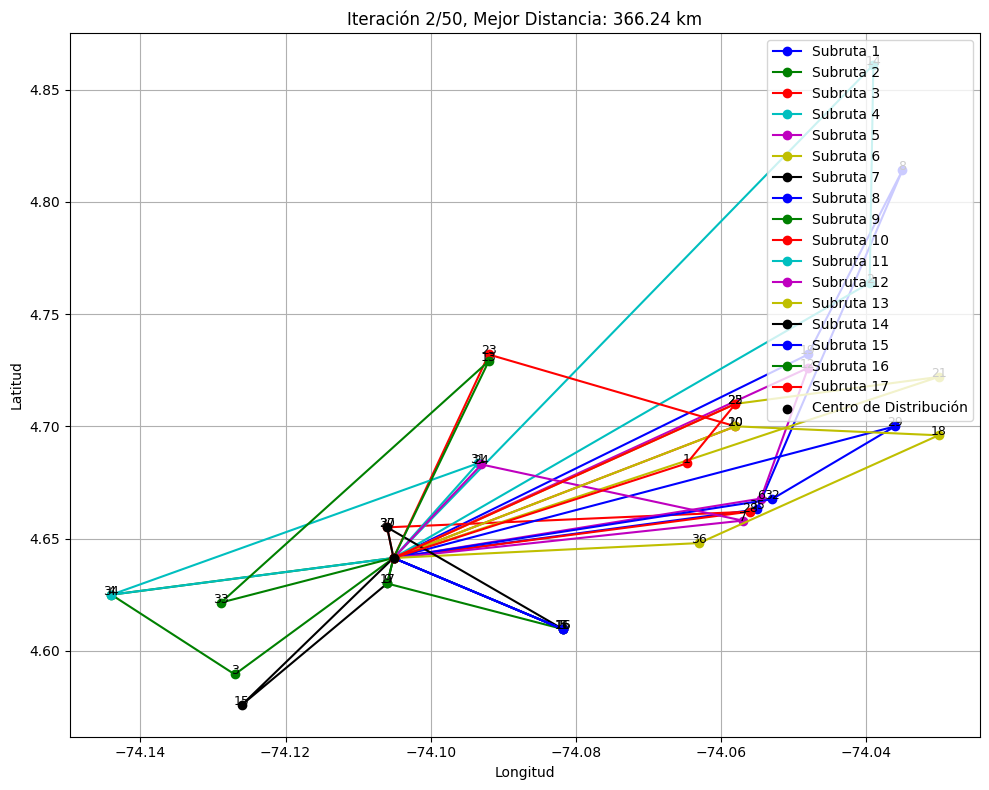

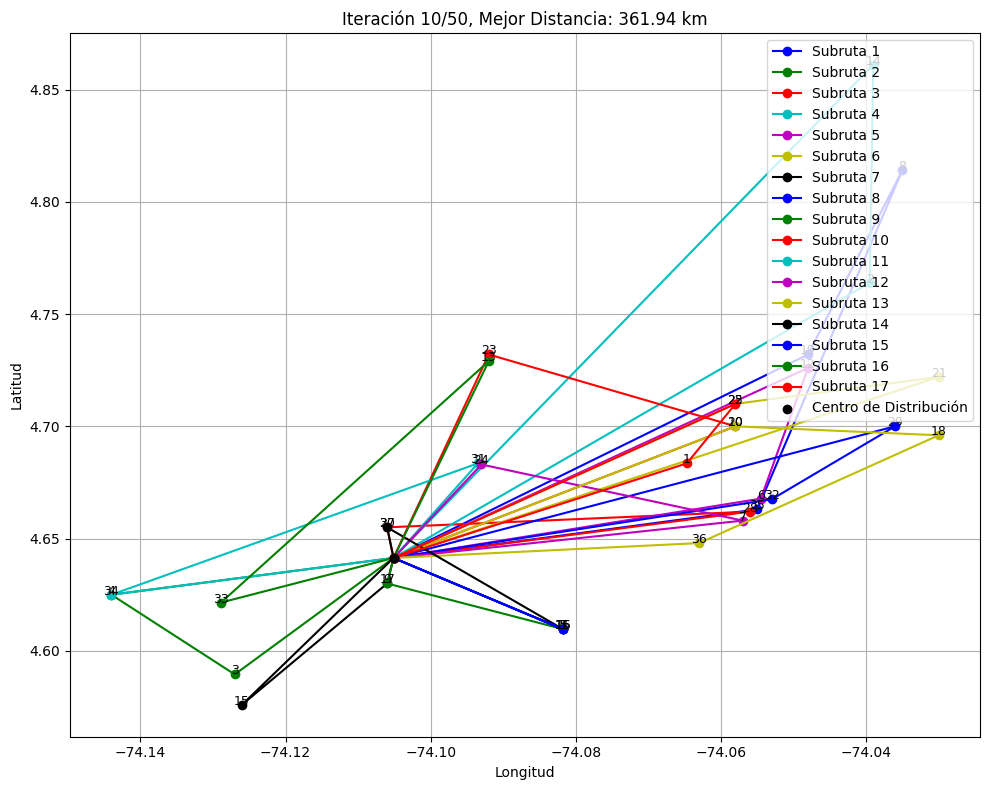

In [18]:
# Visualizar rutas cuando hay cambio de fitness
visualizar_rutas_cambio_fitness(centro_distribucion, coordenadas, pso, ids_centros_comerciales)

# **Referencias**

An Introduction to Particle Swarm Optimization (PSO Algorithm)

https://www.analyticsvidhya.com/blog/2021/10/an-introduction-to-particle-swarm-optimization-algorithm/


Understanding Particle Swarm Optimization (PSO): From Basics to Brilliance

https://thisisrishi.medium.com/understanding-particle-swarm-optimization-pso-from-basics-to-brilliance-d0373ad059b6


Particle Swarm Optimization (PSO) Visually Explained


https://towardsdatascience.com/particle-swarm-optimization-visually-explained-46289eeb2e14


Particle Swarm Optimization (PSO)


https://www.kaggle.com/code/meryentr/particle-swarm-optimization-pso


Particle swarm optimization


https://en.wikipedia.org/wiki/Particle_swarm_optimization

